# Notebook 2: Importance Weighting
In this notebook, we work through some practical examples that demonstrate how importance weighting works. We:

1. Compute importance-weighted accuracy estimates for some synthetic data
2. Compute importance-weighted accuracy estimates for the ML pipeline data
3. Compare different binning functions' accuracy estimates

This notebook should be completed _after_ the first notebook (`1-pipeline-explore.ipynb`).

In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
from datetime import date, datetime, timedelta
from pipeline import components
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [5]:
# PARAMETERS
train_start_date = date(2020, 1, 1)
train_end_date = date(2020, 1, 31)
inference_start_date = date(2020, 2, 1)
inference_end_date = date(2020, 5, 31)
cadence = 7

feature_columns = [
    "pickup_weekday",
    "pickup_hour",
    "pickup_minute",
    "work_hours",
    "passenger_count",
    "trip_distance",
    "trip_speed",
    "PULocationID",
    "DOLocationID",
    "RatecodeID",
    "congestion_surcharge",
    "loc_code_diffs",
]
label_column = "high_tip_indicator"

## Synthetic data examples

This section will not have any code.

Recall that many times during deployments, we may not have access to ground-truth labels for the predictions we make. The goal here is to estimate model performance on our unlabeled predictions. We want our estimations of metrics to be as close to the real metrics as possible.

To estimate model metric performance (e.g., accuracy), we come up with a *binning function* that maps a record (features) to some bin. Then, we precompute training metrics for each bin. At inference time, we assign each record to its corresponding bin. Whenever we want to retrieve a metric estimate, we multiply each bin's training accuracy by the *weight* of each bin (how many records are in each bin) and divide by the total number of records.

### Questions

Suppose we have 5 bins:

| **Bin** | **Training Accuracy** |
|---------|--------------|
| A       | 90%          |
| B       | 80%          |
| C       | 83%          |
| D       | 95%          |
| E       | 96%          |

1. At inference time, we see 4 records that are assigned to bins A, B, C, and D. What is the resulting accuracy estimate?
2. At inference time, we see 2 records that are both assigned to bin A. What is the resulting accuracy estimate?
3. At inference time, we see 6 records that are assigned to bins A, B, A, B, and C. What is the resulting accuracy estimate?

We can also update our estimates once we receive true labels for predictions.

4. At inference time, we see 4 records that are assigned to bins A, B, C, and D. Then, we receive information that the first two records were predicted correctly. What is the resulting accuracy estimate?
5. At inference time, we see 4 records that are assigned to bins A, B, C, and D. Then, we receive information that all records are predicted correctly. What is the resulting accuracy estimate?
6. At inference time, we see 4 records that are assigned to bins A, B, C, and D. Then, we receive information that the first record was predicted correctly and the second record was predicted incorrectly. What is the resulting accuracy estimate?

## ML Pipeline Data

We first need to come up with a binning function for our taxi data. Let's start simple -- let's make bins based on pickup time hour. How many bins will we have?

In [4]:
def pickup_hour_bin(pickup_time: datetime) -> int:
    return int(pickup_time.hour)

Then, we will compute training accuracies for each bin. What do you notice -- what hours are the model good at predicting, and what hours are the model bad at predicting?

In [6]:
# Clean and featurize data
df = components.load_data(train_start_date, train_end_date)
clean_df = components.clean_data(df, train_start_date, train_end_date)
features_df = components.featurize_data(clean_df)
train_predictions, train_scores = components.inference(features_df, feature_columns, label_column)

In [17]:
train_predictions["bin"] = train_predictions["tpep_pickup_datetime"].apply(pickup_hour_bin)
train_bin_accuracies = train_predictions.groupby("bin")[[label_column, "prediction"]].apply(lambda record: accuracy_score(record[label_column].astype(int), record["prediction"].round())).to_frame(name = "accuracy")

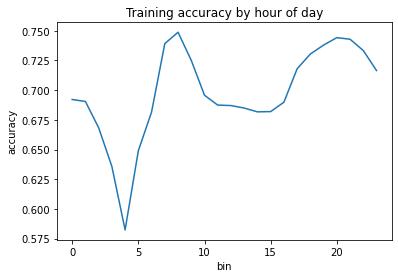

In [21]:
plt.title("Training accuracy by hour of day")
sns.lineplot(x = "bin", y = "accuracy", data = train_bin_accuracies)
plt.show()

Now, we can use these accuracies to estimate accuracy on February 1, 2020 data and beyond.

In [23]:
true_results = {}
estimated_results = {}
prev_dt = inference_start_date

for n in range(7, int((inference_end_date - inference_start_date).days) + 1, 7):
    curr_dt = inference_start_date + timedelta(n)
    df = components.load_data(prev_dt, curr_dt)
    clean_df = components.clean_data(df, prev_dt, curr_dt)
    features_df = components.featurize_data(clean_df)
    inference_predictions, scores = components.inference(features_df, feature_columns, label_column)
    
    # Add prediction counts
    inference_predictions["bin"] = inference_predictions["tpep_pickup_datetime"].apply(pickup_hour_bin)
    inference_counts = inference_predictions.groupby("bin")["prediction"].count().to_frame(name = "count")
    inference_counts = inference_counts.merge(train_bin_accuracies, on = "bin", how = "left")
    estimated_accuracy = sum(inference_counts["count"] * inference_counts["accuracy"]) / sum(inference_counts["count"])
    
    true_results[prev_dt] = scores["accuracy_score"]
    estimated_results[prev_dt] = estimated_accuracy
    prev_dt = curr_dt

result_df = pd.DataFrame({"date": true_results.keys(), "real_accuracy": true_results.values(), "estimated_accuracy": estimated_results.values()})

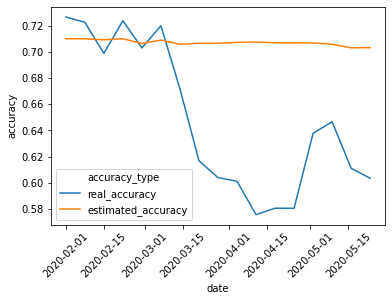

In [26]:
plot_df = result_df.melt(id_vars = ["date"], value_vars = ["real_accuracy", "estimated_accuracy"], var_name = "accuracy_type", value_name = "accuracy")
sns.lineplot(x = "date", y = "accuracy", hue = "accuracy_type", data = plot_df)
plt.xticks(rotation = 45)
plt.show()

Looks like the real accuracy diverged a lot from the estimated accuracy, meaning that our estimates were really bad! Can we do better by coming up with finer-grained bins?

### Exercise

Plot accuracies over times with binning functions based on the following:

* Pickup location ID
* Dropoff location ID
* Passenger count
* Trip distance

You can decide how you want to bin real-valued variables.

